# AlgoTrading Curse Final project

# This notebook contains several main parts:
### 1. imports
### 2. Download Data from Yahoo Finance and employment data
### 3. Run statistics on the data
### 4. Clean Data with Noise
### 5. Clean Data with VIF Higher than 8
### 6. Forecast LSTM Model
### 7. Forecast ARIMA Model
### 8. Forecast Prophet Model
### 9. Summary of Model Performance

### Step 1: Import Required Libraries

In [ ]:
#Installing yfinance library
!pip install yfinance

!pip install ta
!pip install prophet

  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.2.5-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.8/3.0 MB 2.2 MB/s eta 0:00:01
     ------------- -------------------------- 1.0/3.0 MB 2.5 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/3.0 MB 1.6 MB/s eta 0:00:02
     --------------------------- ------------ 2.1/3.0 MB 2.2 MB/s eta 0:00:01
     ------------------------------- -------- 2.4/3.0 MB 2.3 MB/s eta 0:00:01
     -------------------------------------- - 2.9/3.0 

In [2]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from datetime import datetime

import yfinance as yf

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# Data preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Time series models and statistical analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Deep learning models
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Financial indicators
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Anomaly detection
from scipy.stats import zscore

# Forecasting
from prophet import Prophet

### Step 2: Download Data from Yahoo Finance and employment data

In [3]:
def download_data(tickers, start, end):
    """
    Download stock data from Yahoo Finance for multiple tickers.
    """
    stock_data = pd.DataFrame()
    for name, ticker in tickers.items():
        stock_data[name] = yf.download(ticker, start=start, end=end)['Adj Close']
    return stock_data

def get_and_prepare_employment_data():
    """
    Download employment data from the FRED website and prepare it by resampling
    to daily frequency and interpolating linearly.
    """
    url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=EMRATIO"
    response = requests.get(url)
    data = StringIO(response.text)
    employment_data = pd.read_csv(data, parse_dates=['DATE'], index_col='DATE')
    employment_data.columns = ['Employment-Population Ratio']
    employment_data['Employment-Population Ratio'] /= 100  # Convert to percentage

    # Convert the index to datetime format and resample to daily frequency with linear interpolation
    employment_data.index = pd.to_datetime(employment_data.index)
    employment_data = employment_data.resample("D").interpolate(method='linear')

    return employment_data

def add_technical_indicators(df):
    """
    Add RSI and MACD indicators to the DataFrame.
    """
    # Initialize the RSI and MACD indicators
    rsi_indicator = RSIIndicator(df['target_ticker'])
    macd_indicator = MACD(df['target_ticker'])

    # Calculate RSI and MACD
    df['RSI'] = rsi_indicator.rsi()
    df['MACD'] = macd_indicator.macd() # Moving Average Convergence Divergence
    df['MACD Signal'] = macd_indicator.macd_signal()
    df['MACD Histogram'] = macd_indicator.macd_diff()

    return df

In [4]:
tickers = {
    'target_ticker': 'AAPL',
    'Dow_Jones': '^DJI',
    'MSCI_ACWI': 'ACWX',
    'Treasury_Bond_ETF': 'IEI',
    'tech_index': 'XLK',
    'finance_index': 'XLF',
    'european_index': 'VGK'
}

start_date = '2015-01-01'
end_date = '2024-06-26'

# Download stock data for multiple tickers
tickers_data = download_data(tickers, start_date, end_date)

# Download and prepare employment data
employment_data = get_and_prepare_employment_data()

# Combine data into a single DataFrame
combined_tickers_employment_data = tickers_data.copy()
combined_tickers_employment_data['Employment-Population Ratio'] = employment_data['Employment-Population Ratio']

# Add technical indicators to the target ticker's data
combined_data = add_technical_indicators(combined_tickers_employment_data)

print(combined_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


            target_ticker     Dow_Jones  MSCI_ACWI  Treasury_Bond_ETF  \
Date                                                                    
2015-01-02      24.402170  17832.990234  33.250900         104.920799   
2015-01-05      23.714727  17501.650391  32.527718         105.160408   
2015-01-06      23.716957  17371.640625  32.193340         105.485687   
2015-01-07      24.049520  17584.519531  32.558811         105.579849   
2015-01-08      24.973555  17907.869141  33.033161         105.451492   

            tech_index  finance_index  european_index  \
Date                                                    
2015-01-02   36.564392      16.717278       38.076954   
2015-01-05   36.006210      16.365763       36.966930   
2015-01-06   35.572094      16.115643       36.550659   
2015-01-07   35.873318      16.284637       36.930412   
2015-01-08   36.661835      16.527994       37.463520   

            Employment-Population Ratio  RSI  MACD  MACD Signal  \
Date                 

### Step 3: Run statistics on the data

In [5]:
# Basic statistics: min, max, mean, etc.
summary_stats = combined_data.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
        target_ticker     Dow_Jones    MSCI_ACWI  Treasury_Bond_ETF  \
count    2385.000000   2385.000000  2385.000000        2385.000000   
mean       87.087322  26916.123077    41.467301         113.308129   
std        59.314961   6668.326195     6.596639           6.055919   
min        20.744020  15660.179688    27.740831         104.798210   
25%        33.970181  20954.339844    35.995888         108.385010   
50%        54.347656  26287.439453    40.978344         111.068405   
75%       145.464279  33420.769531    46.956009         117.048134   
max       216.669998  40003.589844    54.314743         125.530792   

        tech_index  finance_index  european_index  \
count  2385.000000    2385.000000     2385.000000   
mean     96.104632      26.162561       48.420633   
std      51.049436       7.452939        8.774287   
min      33.689041      13.547802       31.974403   
25%      50.828968      20.451561       41.274605   
50%      76.993568      24.649

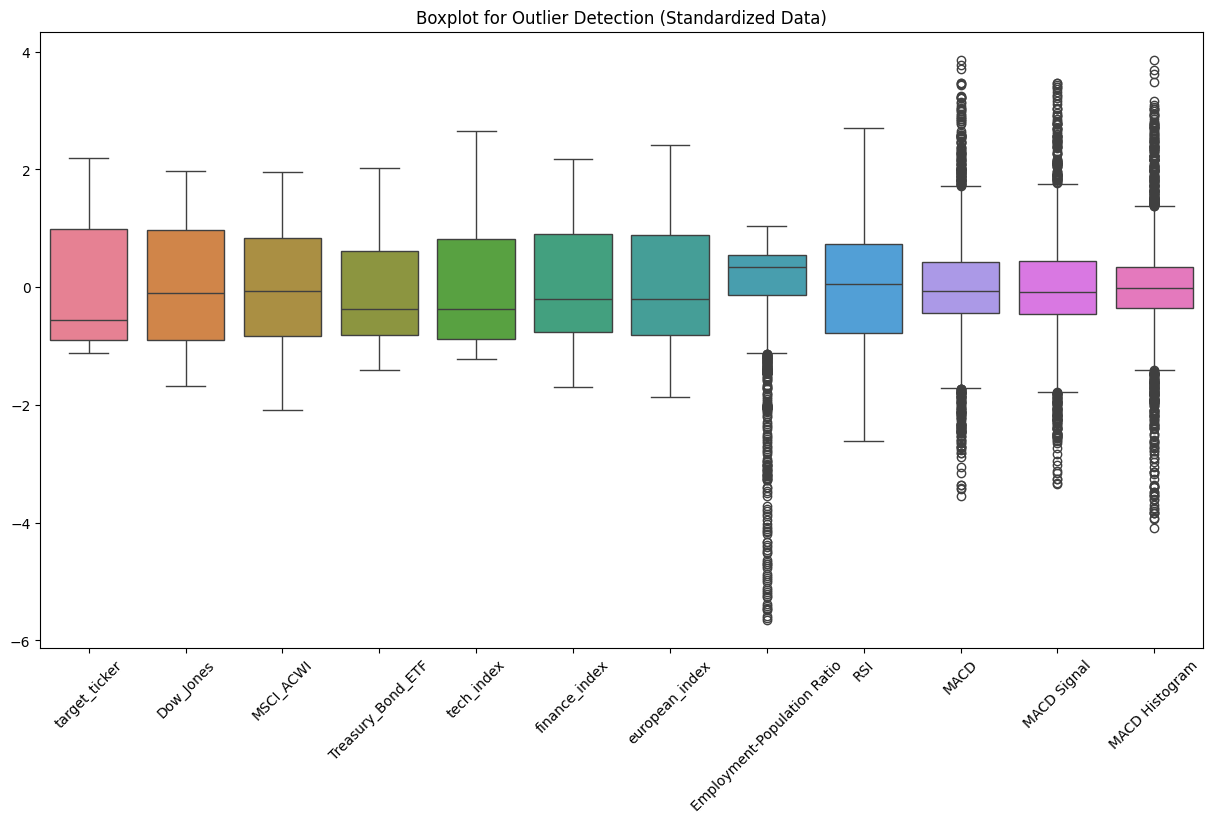

In [6]:
# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Create a DataFrame with the scaled data to preserve column names
scaled_df = pd.DataFrame(scaled_data, columns=combined_data.columns, index=combined_data.index)

# Visual detection of outliers using a boxplot on standardized data
plt.figure(figsize=(15, 8))
sns.boxplot(data=scaled_df)
plt.title('Boxplot for Outlier Detection (Standardized Data)')
plt.xticks(rotation=45)
plt.show()

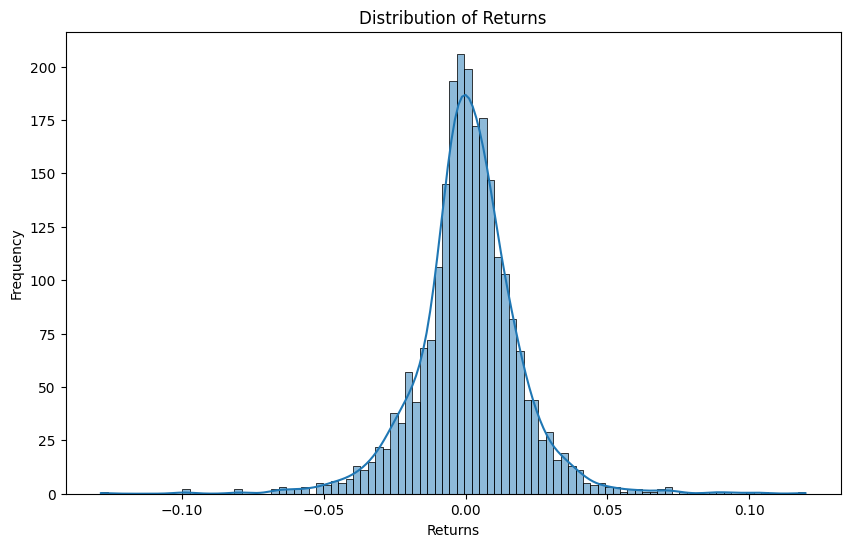

In [7]:
# Displot of returns
returns = combined_data['target_ticker'].pct_change().dropna()
plt.figure(figsize=(10, 6))
sns.histplot(returns, kde=True)
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

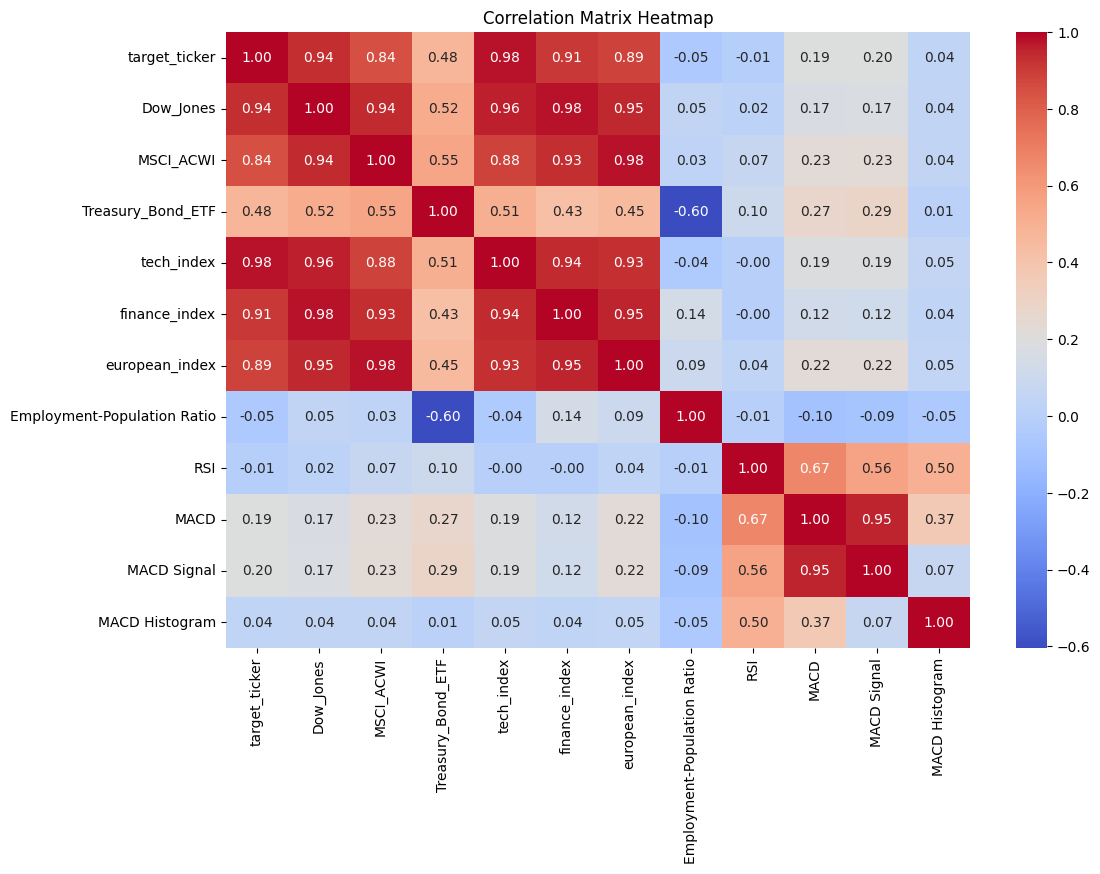

In [8]:
# Compute correlation between all variables
correlation_matrix = combined_data.corr()

# Visualization of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
# Probability analysis of returns
mean_return = np.mean(returns)
std_return = np.std(returns)
prob_positive_return = np.mean(returns > 0)
prob_negative_return = np.mean(returns < 0)

print(f"Mean Return: {mean_return:.4f}")
print(f"Standard Deviation of Returns: {std_return:.4f}")
print(f"Probability of Positive Return: {prob_positive_return:.4f}")
print(f"Probability of Negative Return: {prob_negative_return:.4f}")

Mean Return: 0.0011
Standard Deviation of Returns: 0.0182
Probability of Positive Return: 0.5277
Probability of Negative Return: 0.4702


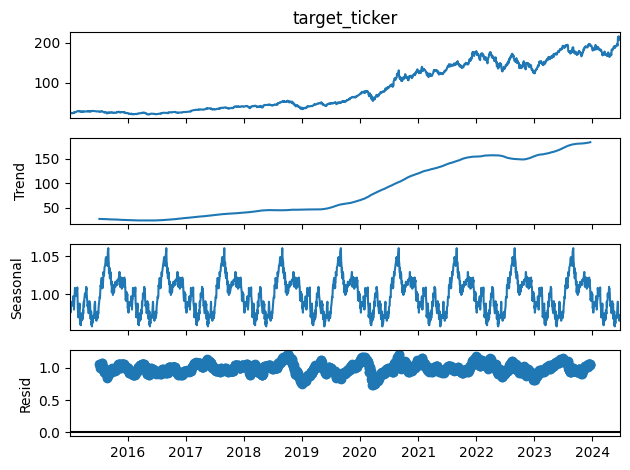

In [10]:
# 1. Seasonal Decomposition (Trend, Seasonal, Residual)
decomposition = seasonal_decompose(combined_data['target_ticker'], model='multiplicative', period=252) # Assuming daily data with 252 trading days per year
decomposition.plot()
plt.show()

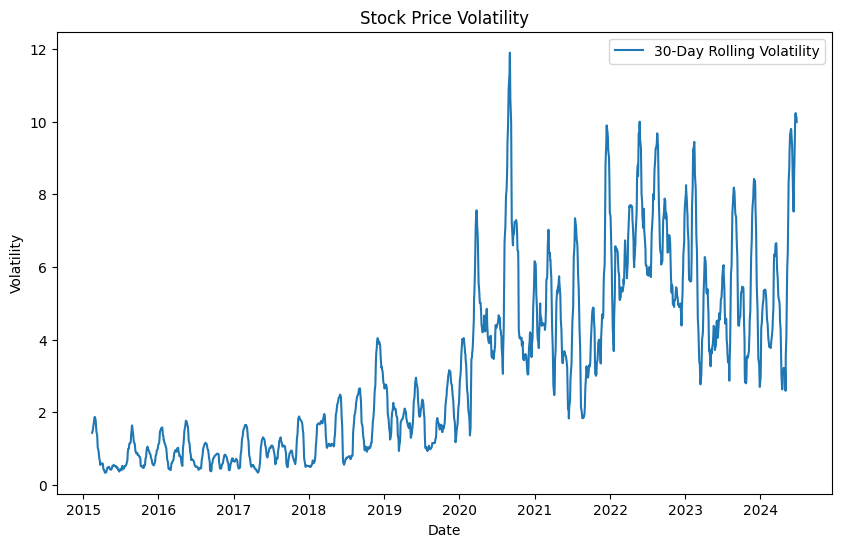

In [11]:
# 2. Volatility (Rolling Standard Deviation)
volatility = combined_data['target_ticker'].rolling(window=30).std() # 30-day rolling window
plt.figure(figsize=(10, 6))
plt.plot(volatility, label='30-Day Rolling Volatility')
plt.title('Stock Price Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

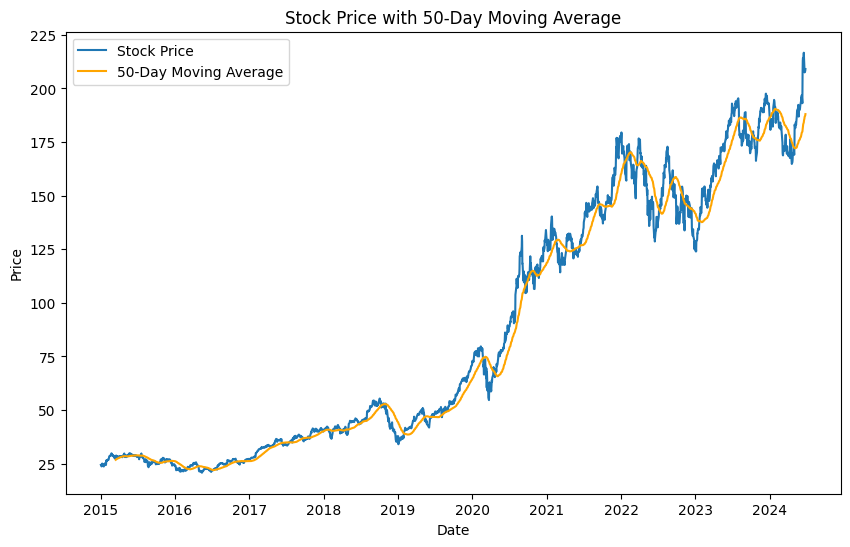

In [12]:
# 3. Trend Visualization with Moving Average
moving_average = combined_data['target_ticker'].rolling(window=50).mean() # 50-day moving average
plt.figure(figsize=(10, 6))
plt.plot(combined_data['target_ticker'], label='Stock Price')
plt.plot(moving_average, label='50-Day Moving Average', color='orange')
plt.title('Stock Price with 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
# 4. Stationarity Test (Augmented Dickey-Fuller Test)
result = adfuller(combined_data['target_ticker'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.270483
p-value: 0.975949
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


<Figure size 1000x600 with 0 Axes>

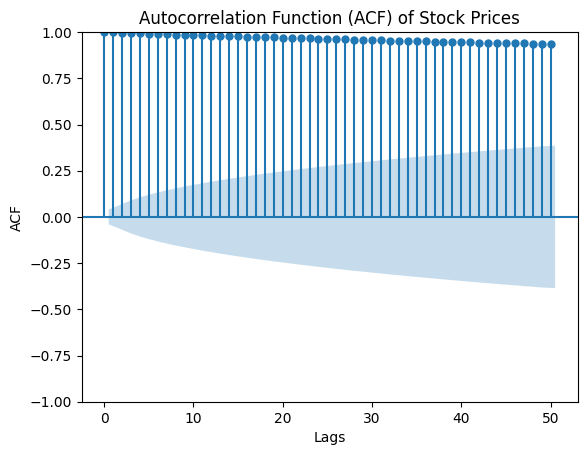

In [14]:
# 5. Autocorrelation Analysis (ACF Plot)
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(combined_data['target_ticker'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) of Stock Prices')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

### Step 4: Clean Data with Noise

In [15]:
# 1. Remove missing values
combined_data = combined_data.dropna()

# 2. Remove outliers using a more lenient method
def remove_outliers(df, column, threshold=5):
    """
    Remove outliers using z-score.

    Parameters:
    - df: DataFrame
    - column: Column name to check for outliers
    - threshold: Z-score threshold to consider a value as an outlier

    Returns:
    - DataFrame with outliers removed
    """
    # Calculate z-scores for the specified column
    df['zscore'] = zscore(df[column])
    # Filter out rows where the absolute z-score is above the threshold
    df_filtered = df[np.abs(df['zscore']) < threshold]
    # Drop the zscore column used for filtering
    df_filtered = df_filtered.drop(columns=['zscore'])

    return df_filtered

# Apply the outlier removal function to each numeric column in the DataFrame
for column in combined_data.columns:
    if pd.api.types.is_numeric_dtype(combined_data[column]):
        combined_data = remove_outliers(combined_data, column, threshold=5)  # Adjust threshold as needed

<ipython-input-15-0ce8238619f7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zscore'] = zscore(df[column])


### Step 5: Clean Data with VIF Higher than 8

In [16]:
print(combined_data)

            target_ticker     Dow_Jones  MSCI_ACWI  Treasury_Bond_ETF  \
Date                                                                    
2015-02-20      29.018137  18140.439453  35.156055         105.202766   
2015-02-23      29.802414  18116.839844  34.984985         105.451302   
2015-02-24      29.616425  18209.189453  35.249367         105.862572   
2015-02-25      28.859035  18224.570312  35.280472         105.905441   
2015-02-26      29.224281  18214.419922  35.202721         105.494118   
...                   ...           ...        ...                ...   
2024-06-18     214.289993  38834.859375  53.200001         115.268532   
2024-06-20     209.679993  39134.761719  53.200001         115.129272   
2024-06-21     207.490005  39150.328125  52.889999         115.149170   
2024-06-24     208.139999  39411.210938  53.240002         115.179008   
2024-06-25     209.070007  39112.160156  53.290001         115.248642   

            tech_index  finance_index  european_in

In [17]:
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Function to remove features with VIF > 8
def remove_high_vif_features(df, threshold=8):
    ticker_column = df['target_ticker']
    df = df.drop(columns=['target_ticker'])

    while True:
        vif_data = calculate_vif(df)
        print(vif_data['VIF'])
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold:
            feature_to_remove = vif_data.loc[vif_data['VIF'] == max_vif, 'feature'].values[0]
            print(f"Removing {feature_to_remove} with VIF {max_vif}")
            df = df.drop(columns=[feature_to_remove])
        else:
            break

    df.insert(0, 'target_ticker', ticker_column)
    return df

# Calculate percentage change and remove rows with NaN values
# combined_data_pct = combined_data.pct_change() * 100
# combined_data_pct['target_ticker'] = combined_data['target_ticker']
# combined_data_pct = combined_data_pct.dropna()

# Removing high VIF features
# cleaned_data = remove_high_vif_features(combined_data_pct)
cleaned_data = remove_high_vif_features(combined_data)


# Display the shape and the first few rows of the cleaned data
print(cleaned_data.shape)
print(cleaned_data.head())


0     1169.623114
1     2796.469184
2      704.518389
3      144.642653
4      610.857153
5     2568.465328
6      662.795681
7       42.732522
8             inf
9             inf
10            inf
Name: VIF, dtype: float64
Removing MACD with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0    1169.623114
1    2796.469184
2     704.518389
3     144.642653
4     610.857153
5    2568.465328
6     662.795681
7      42.732522
8       2.122178
9       1.519706
Name: VIF, dtype: float64
Removing MSCI_ACWI with VIF 2796.469184037579
0    991.858539
1    410.822117
2     73.587560
3    610.579127
4    435.442827
5    378.419598
6     42.386733
7      2.096294
8      1.519020
Name: VIF, dtype: float64
Removing Dow_Jones with VIF 991.8585394831974
0    299.730278
1     53.351216
2    234.961981
3    435.020599
4    372.371869
5     42.110162
6      2.092986
7      1.514769
Name: VIF, dtype: float64
Removing european_index with VIF 435.02059911967063
0    287.568519
1     50.728851
2    137.388343
3    331.009623
4     41.915481
5      1.948087
6      1.508766
Name: VIF, dtype: float64
Removing Employment-Population Ratio with VIF 331.009623498828
0     59.484502
1     39.212077
2    111.545497
3     40.219630
4      1.835956
5      1.499177
Name: VIF, dtype: float64
Removing fina

### Step 6: Forecast Model LSTM


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2162/2162 ━━━━━━━━━━━━━━━━━━━━ 132s 58ms/step - loss: 0.0054
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
LSTM RMSE: 10.150903429481815
LSTM R^2: 0.31670813392719466


<ipython-input-18-c398a0b3e306>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


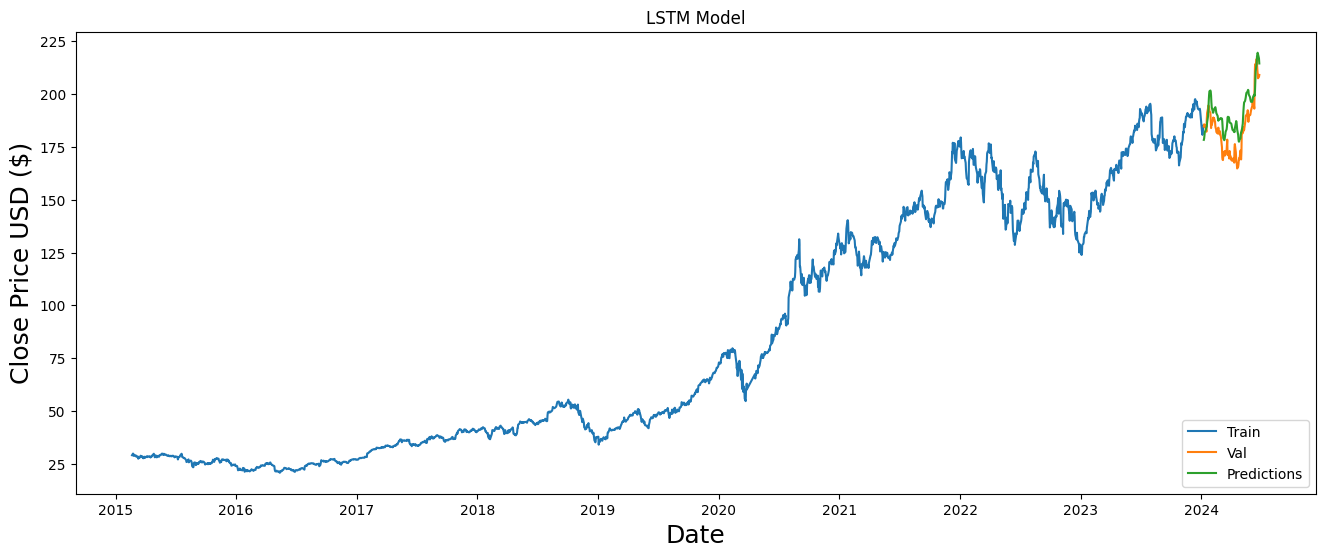

            target_ticker  tech_index        RSI  MACD Signal  MACD Histogram  \
Date                                                                            
2024-01-09     184.653595  188.397827  40.633710    -0.097436       -1.498921   
2024-01-10     185.700836  190.002365  43.357416    -0.396663       -1.196910   
2024-01-11     185.102417  190.969070  42.166899    -0.641524       -0.979445   
2024-01-12     185.431549  191.586975  43.092431    -0.832760       -0.764944   
2024-01-16     183.147568  192.065338  38.489218    -1.014902       -0.728566   
...                   ...         ...        ...          ...             ...   
2024-06-18     214.289993  231.004745  73.634787     6.523496        1.660152   
2024-06-20     209.679993  228.409302  65.265105     6.794248        1.083007   
2024-06-21     207.490005  228.009995  61.678489     6.909945        0.462789   
2024-06-24     208.139999  222.419998  62.340000     6.917013        0.028272   
2024-06-25     209.070007  2

In [18]:
# Initialize lists to store metrics for each model
rmse_values = []
r2_values = []
model_names = ['LSTM', 'ARIMA', 'Prophet']

# -------------------------------------
# LSTM Model
# -------------------------------------

# Prepare the data
dataset = cleaned_data.values
training_data_len = int(np.ceil(len(dataset) * 0.95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create training data
train_data = scaled_data[:training_data_len]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
num_features = x_train.shape[2]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_features))

# Build and train the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create testing data
test_data = scaled_data[training_data_len - 60:]
x_test = [test_data[i-60:i] for i in range(60, len(test_data))]
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], num_features-1)))))[:, 0]

# Calculate RMSE
y_test = dataset[training_data_len:, 0]
rmse_lstm = np.sqrt(np.mean((predictions - y_test) ** 2))
r2_lstm = r2_score(y_test, predictions)
print(f'LSTM RMSE: {rmse_lstm}')
print(f'LSTM R^2: {r2_lstm}')

# Store metrics
rmse_values.append(rmse_lstm)
r2_values.append(r2_lstm)

# Plot the results
train = cleaned_data[:training_data_len]
valid = cleaned_data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['target_ticker'])
plt.plot(valid[['target_ticker', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Display the actual and predicted prices
print(valid)

### Step 7: Forecast ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-19-b9862e1a380d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

ARIMA RMSE: 2.8236808788410106
ARIMA R^2: 0.9471277144402739


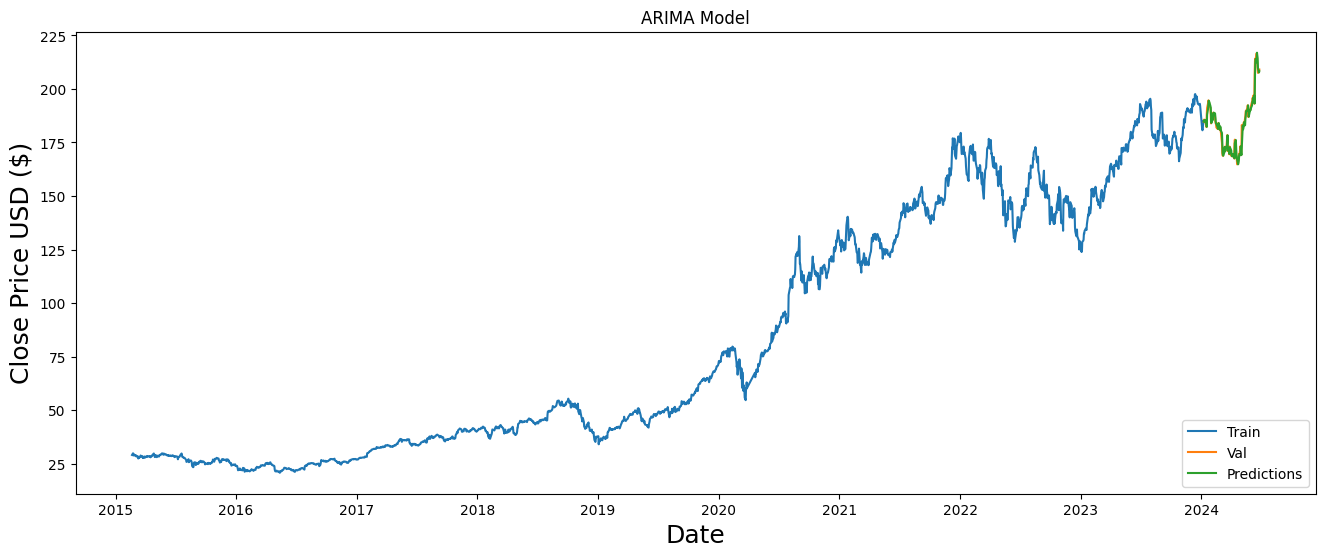

            target_ticker  tech_index        RSI  MACD Signal  MACD Histogram  \
Date                                                                            
2024-01-09     184.653595  188.397827  40.633710    -0.097436       -1.498921   
2024-01-10     185.700836  190.002365  43.357416    -0.396663       -1.196910   
2024-01-11     185.102417  190.969070  42.166899    -0.641524       -0.979445   
2024-01-12     185.431549  191.586975  43.092431    -0.832760       -0.764944   
2024-01-16     183.147568  192.065338  38.489218    -1.014902       -0.728566   
...                   ...         ...        ...          ...             ...   
2024-06-18     214.289993  231.004745  73.634787     6.523496        1.660152   
2024-06-20     209.679993  228.409302  65.265105     6.794248        1.083007   
2024-06-21     207.490005  228.009995  61.678489     6.909945        0.462789   
2024-06-24     208.139999  222.419998  62.340000     6.917013        0.028272   
2024-06-25     209.070007  2

In [19]:
# -------------------------------------
# ARIMA Model
# -------------------------------------

# Split the data into training and testing sets
training_data_len = int(np.ceil(len(cleaned_data) * 0.95))
train_data = cleaned_data.iloc[:training_data_len]
test_data = cleaned_data.iloc[training_data_len:]

# Train the ARIMA model
model = ARIMA(train_data['target_ticker'], order=(5,1,0))
model_fit = model.fit()

# Make predictions recursively
predictions = []
history = list(train_data['target_ticker'])
for t in range(len(test_data)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test_data['target_ticker'].iloc[t])

# Add predictions to the test data
test_data['Predictions'] = predictions

# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(test_data['target_ticker'], test_data['Predictions']))
r2_arima = r2_score(test_data['target_ticker'], test_data['Predictions'])
print(f'ARIMA RMSE: {rmse_arima}')
print(f'ARIMA R^2: {r2_arima}')

# Store metrics
rmse_values.append(rmse_arima)
r2_values.append(r2_arima)

# Plot the results
plt.figure(figsize=(16,6))
plt.title('ARIMA Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['target_ticker'], label='Train')
plt.plot(test_data['target_ticker'], label='Val')
plt.plot(test_data['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

# Display the actual and predicted prices
print(test_data)

### Step 8: Forecast Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlpl86ht/w4l776zu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlpl86ht/rxi4jj1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43491', 'data', 'file=/tmp/tmpzlpl86ht/w4l776zu.json', 'init=/tmp/tmpzlpl86ht/rxi4jj1q.json', 'output', 'file=/tmp/tmpzlpl86ht/prophet_model2wquv8to/prophet_model-20240810132559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 7.096009151532978
Prophet R^2: 0.9857369110268964


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


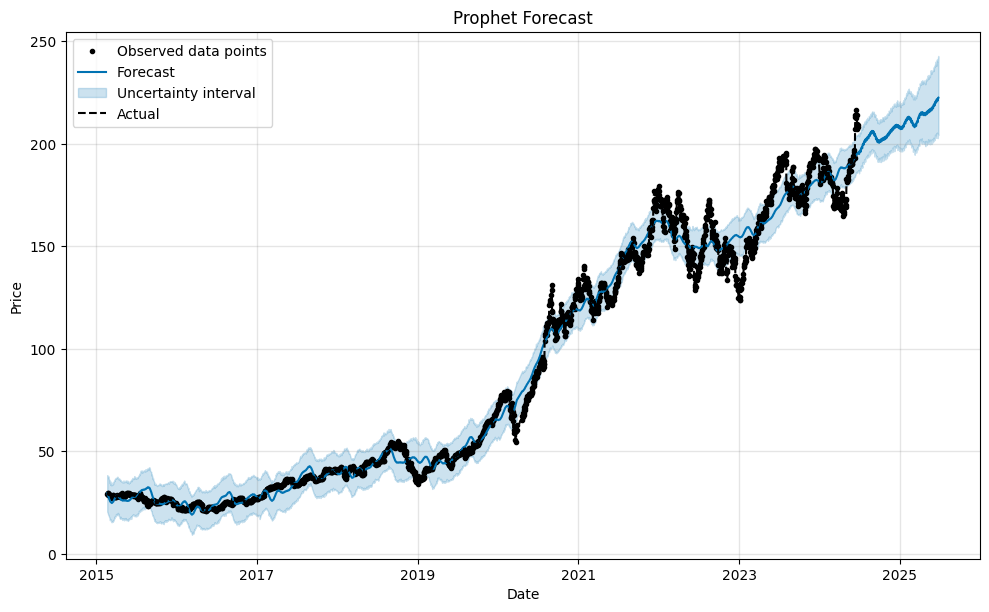

In [20]:
# -------------------------------------
# Prophet Model
# -------------------------------------

# Prepare data for Prophet
def prepare_prophet_data(df):
    df = df.reset_index()
    df = df.rename(columns={'Date': 'ds', 'target_ticker': 'y'})
    return df

# Fit Prophet model
df_prophet = prepare_prophet_data(cleaned_data)
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Make predictions
forecast = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(forecast)

# Extract actual and predicted values for error calculation
actual_values = df_prophet['y'].values
forecast_values = forecast['yhat'][:len(df_prophet)].values

# Calculate RMSE
rmse_prophet = np.sqrt(mean_squared_error(actual_values, forecast_values))
r2_prophet = r2_score(actual_values, forecast_values)
print(f'Prophet RMSE: {rmse_prophet}')
print(f'Prophet R^2: {r2_prophet}')

# Store metrics
rmse_values.append(rmse_prophet)
r2_values.append(r2_prophet)

# Plot the results
def plot_prophet_results(model, forecast, actual_df):
    """
    Plot the forecast results along with historical data.
    """
    fig = model.plot(forecast)
    plt.title('Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Add actual data to the plot
    plt.plot(actual_df['ds'], actual_df['y'], label='Actual', color='black', linestyle='--')
    plt.legend()
    plt.show()

plot_prophet_results(model_prophet, forecast, df_prophet)


In [21]:
# -------------------------------------
# Summary of Model Performance
# -------------------------------------

# Create a DataFrame for summary
summary_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'R^2': r2_values
})

# Display the summary
print("\nSummary of Model Performance:")
print(summary_df)


Summary of Model Performance:
     Model       RMSE       R^2
0     LSTM  10.150903  0.316708
1    ARIMA   2.823681  0.947128
2  Prophet   7.096009  0.985737
